In [2]:
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn import cross_validation, metrics
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import train_test_split
from copy import deepcopy
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

In [25]:
def modelfit(alg, train, test, predictors, target, \
             useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    """From Aarshay Jain's post Complete Guide to Parameter Tunning 
    in XGBoost
    """
    # make a copy
    dtrain = deepcopy(train)
    dtest  = deepcopy(test)
    
    # Cross validation
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, \
                              label=dtrain[target].values, \
                              missing=float('nan'))
        xgtest = xgb.DMatrix(dtest[predictors].values, \
                             label=dtest[target].values, \
                             missing=float('nan'))
        cvresult = xgb.cv(xgb_param, xgtrain, \
                          num_boost_round=alg.get_params()['n_estimators'], \
                          nfold=cv_folds, \
                          metrics=['auc'], \
                          early_stopping_rounds=early_stopping_rounds, \
                          show_progress=False)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain[target],eval_metric='error')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob    = alg.predict_proba(dtrain[predictors])[:,1]
    dtrain['Prediction'] = pd.Series(dtrain_predictions, index=dtrain.index)
    dtrain['predprob']   = pd.Series(dtrain_predprob, index=dtrain.index)
        
    #Print model report:
    print "\nModel Report"
    print "Accuracy : %.4g" % metrics.accuracy_score(
        dtrain[target].values, \
        dtrain_predictions)
    print "AUC Score (Train): %f" % metrics.roc_auc_score(
        dtrain[target], \
        dtrain_predprob)
    
    #Predict on testing data:
    dtest_predictions = alg.predict(dtest[predictors])
    dtest_predprob    = alg.predict_proba(dtest[predictors])[:,1]
    dtest['Prediction'] = pd.Series(dtest_predictions, index=dtest.index)
    dtest['predprob']   = pd.Series(dtest_predprob, index=dtest.index)
    print "Accuracy : %.4g" % metrics.accuracy_score(
        dtest[target].values, \
        dtest_predictions)
    print 'AUC Score (Test): %f' % metrics.roc_auc_score(
        dtest[target], \
        dtest_predprob)
                
    feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

    return dtrain, dtest

In [27]:
df = pd.read_csv('../data/train.csv')
train, test = train_test_split(df, test_size=0.2)
train.shape, test.shape

target = 'earn_over_4k_euros_per_year'
index  = 'Id'
predictors = [x for x in train.columns if x not in [target,index]]

Will train until cv error hasn't decreased in 50 rounds.
Stopping. Best iteration: 117



Model Report
Accuracy : 0.8926
AUC Score (Train): 0.947038
Accuracy : 0.8348
AUC Score (Test): 0.898602


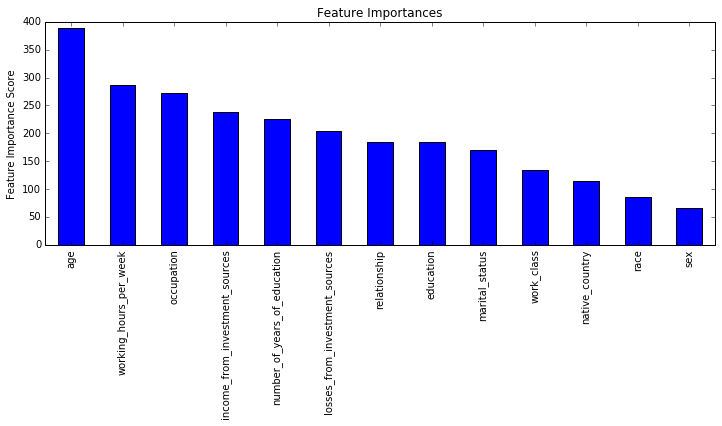

In [39]:
xgb0 = XGBClassifier(
        learning_rate    = 0.1,
        n_estimators     = 1000,
        max_depth        = 5,
        min_child_weight = 1,
        gamma            = 0,
        subsample        = 0.8,
        colsample_bytree = 0.8,
        reg_alpha        = 0.05,
        objective        = 'binary:logistic',
        scale_pos_weight = 1,
        seed             = 27)
train_pred, test_pred = modelfit(xgb0, train, test, predictors, target)



Model Report
Accuracy : 0.8867
AUC Score (Train): 0.941464
Accuracy : 0.84
AUC Score (Test): 0.902012


Will train until cv error hasn't decreased in 50 rounds.


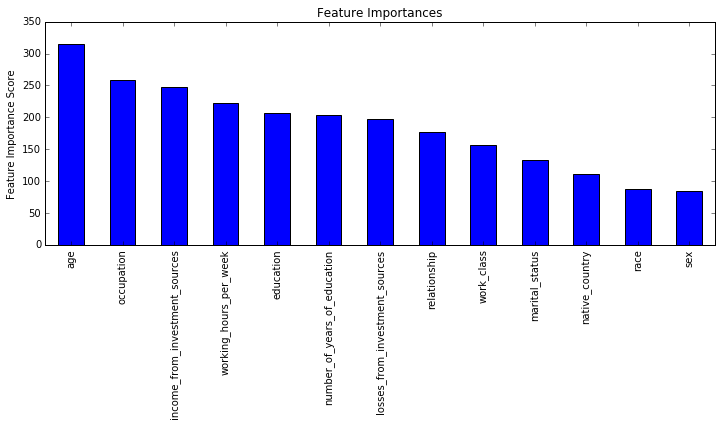

In [31]:
xgb1 = XGBClassifier(
        learning_rate    = 0.1,
        n_estimators     = 120,
        max_depth        = 5,
        min_child_weight = 1,
        gamma            = 0.4,
        subsample        = 0.85,
        colsample_bytree = 0.5,
        reg_alpha        = 0.05,
        objective        = 'binary:logistic',
        scale_pos_weight = 1,
        seed             = 27)
train_pred, test_pred = modelfit(xgb1, train, test, predictors, target)


Model Report
Accuracy : 0.8762
AUC Score (Train): 0.936278


Will train until cv error hasn't decreased in 50 rounds.


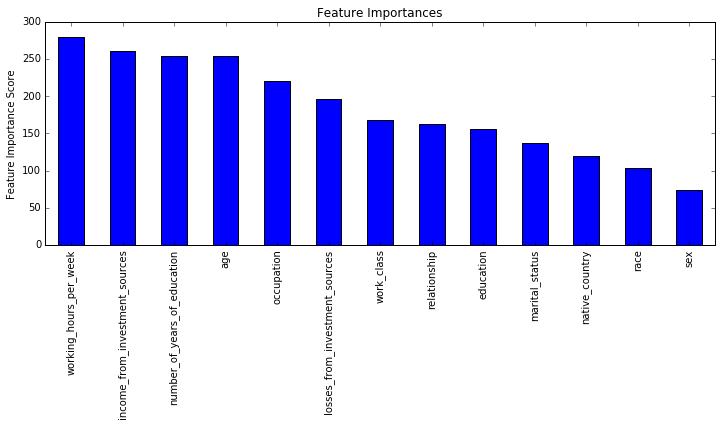

In [22]:
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')
train_pred, test_pred = modelfit(xgb1, train, test, predictors, target)

In [23]:
test_pred[[target,'Prediction']].describe
test_pred.to_csv('../data/tune_1', columns=['Id','Prediction'], \
                 index = False)